![ecg_filter_diagram](./img/ecg_filter_diagram.png)

In [1]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from lms import lms_filter, LmsResult

# plt.style.use('ggplot') # nicer plots
# plt.style.use('seaborn') # nicer plots

np.random.seed(42069) # always use the same random seed to make results comparable

In [2]:
# read ecg.dat into a numpy array
ecg = np.loadtxt('./data/ecg.dat')
nsamples = ecg.shape[0]

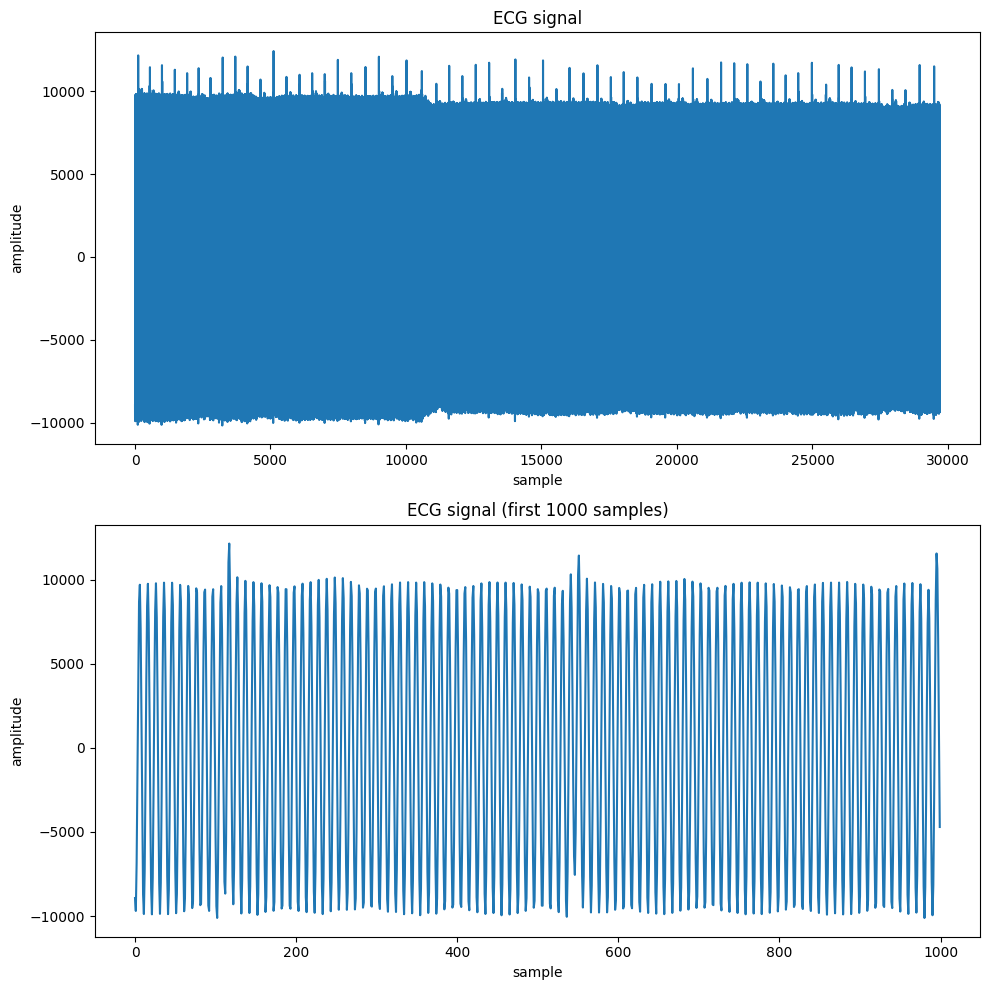

In [3]:
# plot ecg signal twice, once with the original signal and once with the first 1000 samples
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(ecg)
ax[0].set_title('ECG signal')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('amplitude')
ax[1].plot(ecg[:1000])
ax[1].set_title('ECG signal (first 1000 samples)')
ax[1].set_xlabel('sample')
ax[1].set_ylabel('amplitude')
plt.tight_layout()
plt.show()

Power line frequency: 49.56 Hz


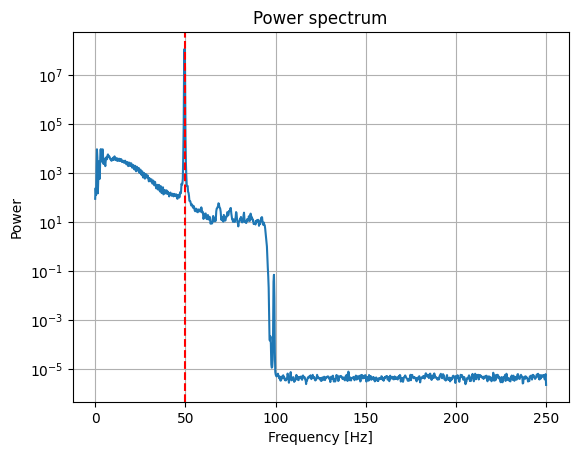

In [4]:
# find power line frequency (50 Hz)
fs = 500 # sampling frequency
f, pxx = sp.signal.welch(ecg, fs, nperseg=2048) # nperseg is the number of samples per segment i.e. the length of the window

max_pxx_idx: int = np.argmax(pxx)
powerline_freq: float = f[max_pxx_idx]
print(f'Power line frequency: {powerline_freq:.2f} Hz')

# plot power spectrum
plt.figure()
plt.plot(f, pxx)
plt.title('Power spectrum')
plt.xlabel('Frequency [Hz]')
plt.yscale('log') # more meaningful scale
plt.grid()
plt.ylabel('Power')
plt.axvline(x=powerline_freq, color='red', linestyle='--')
plt.savefig('./img/ecg_power_spectrum.png')
plt.show()

## 2  How many filter coeffcients are needed in the adaptive filter?

We have **1** frequency (50 Hz) that we want to affect, so we need **2** taps. <br>
With 1 tap we can only affect the gain of the signal, as we only have a scalar in H(z) <br>
With 2 taps we can affect both the gain and phase of the signal, as H(z) = a + bz^-1

In [5]:
ntaps = 2

## 3  Implement an LMS filter which removes the ECG signal from a generated sinusoid at the power line frequency.

In [6]:
# input signal is cos(2*pi*50*t)
t = np.arange(nsamples) / fs
x = np.cos(2 * np.pi * powerline_freq * t)

## 4  Select an appropriate value for the step-size μ.

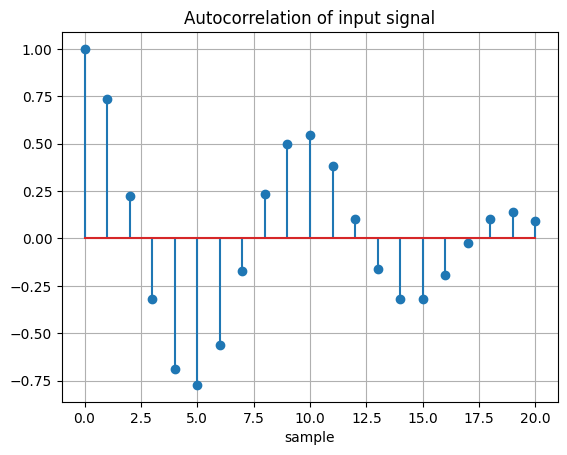

In [7]:
lags = 21

rx = sp.signal.correlate(x[:lags], x[:lags], mode='full')
rx = rx[(rx.size//2):] # take only the positive lags
rx /= rx[0] # normalize

# toepliz matrix
Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):]) # take only the positive lags
# see equ. 6.73 for why we slice [:ntaps, :ntaps]
Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):])[:ntaps, :ntaps] # take only the positive lags

# plot autocorrelation of input signal
plt.figure()
plt.stem(rx)
plt.title('Autocorrelation of input signal')
plt.grid()
plt.xlabel('sample')
plt.show()

![lms-stability-condition](./screenshots/stability-condition-for-lms.png)

In [8]:
trR = np.trace(Rxx)

upper_limit_for_learning_rate_with_lms = 1 / (3 * trR)
upper_limit_for_learning_rate_with_lms

print(f'0 < mu < {upper_limit_for_learning_rate_with_lms:.2f}')

0 < mu < 0.31


In [9]:
mu = 0.3 # step size between 0 and 1 / (3 * trR)

lms_result: LmsResult = lms_filter(x, ecg, mu, ntaps)
y = lms_result.y
err = lms_result.err
w = lms_result.w

##  5 Examine the error-signal e(k) by plotting it and comparing it with the original noisy ECG-signal.

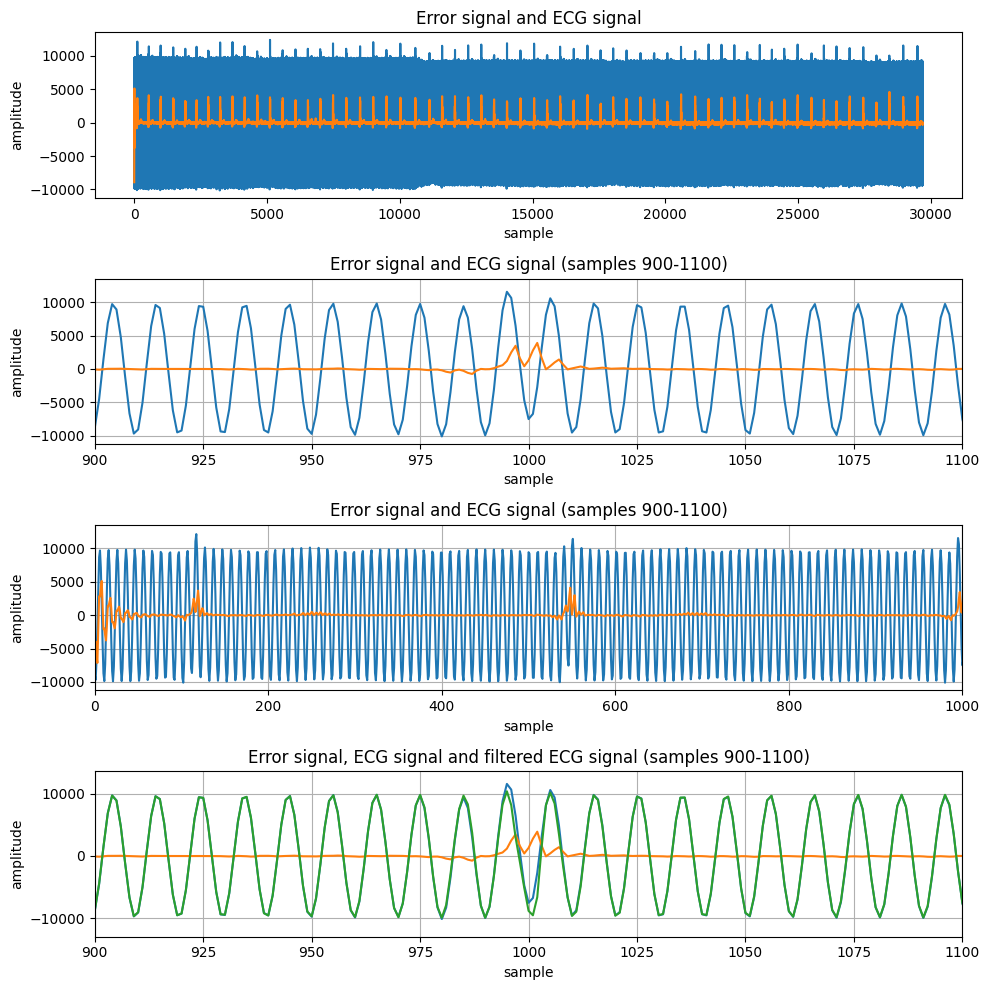

In [10]:
# plot error signal and ecg signal, fist with all samples and then with the first 1000 samples
_, ax = plt.subplots(4, 1, figsize=(10, 10))
ax[0].plot(ecg)
ax[0].plot(err)
ax[0].set_title('Error signal and ECG signal')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('amplitude')

ax[1].plot(ecg)
ax[1].plot(err)
ax[1].set_title('Error signal and ECG signal (samples 900-1100)')
ax[1].set_xlabel('sample')
ax[1].set_xlim(900, 1100)
ax[1].grid()
ax[1].set_ylabel('amplitude')

ax[2].plot(ecg)
ax[2].plot(err)
ax[2].set_title('Error signal and ECG signal (samples 900-1100)')
ax[2].set_xlabel('sample')
ax[2].set_xlim(0, 1000)
ax[2].grid()
ax[2].set_ylabel('amplitude')

ax[3].plot(ecg)
ax[3].plot(err)
ax[3].plot(y)
ax[3].set_title('Error signal, ECG signal and filtered ECG signal (samples 900-1100)')
ax[3].set_xlabel('sample')
ax[3].set_xlim(900, 1100)
ax[3].grid()
ax[3].set_ylabel('amplitude')

plt.tight_layout()
plt.show()

/tmp/ipykernel_53319/3524613480.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1].scatter(w[:, 0], w[:, 1], cmap=viridis,s=1)


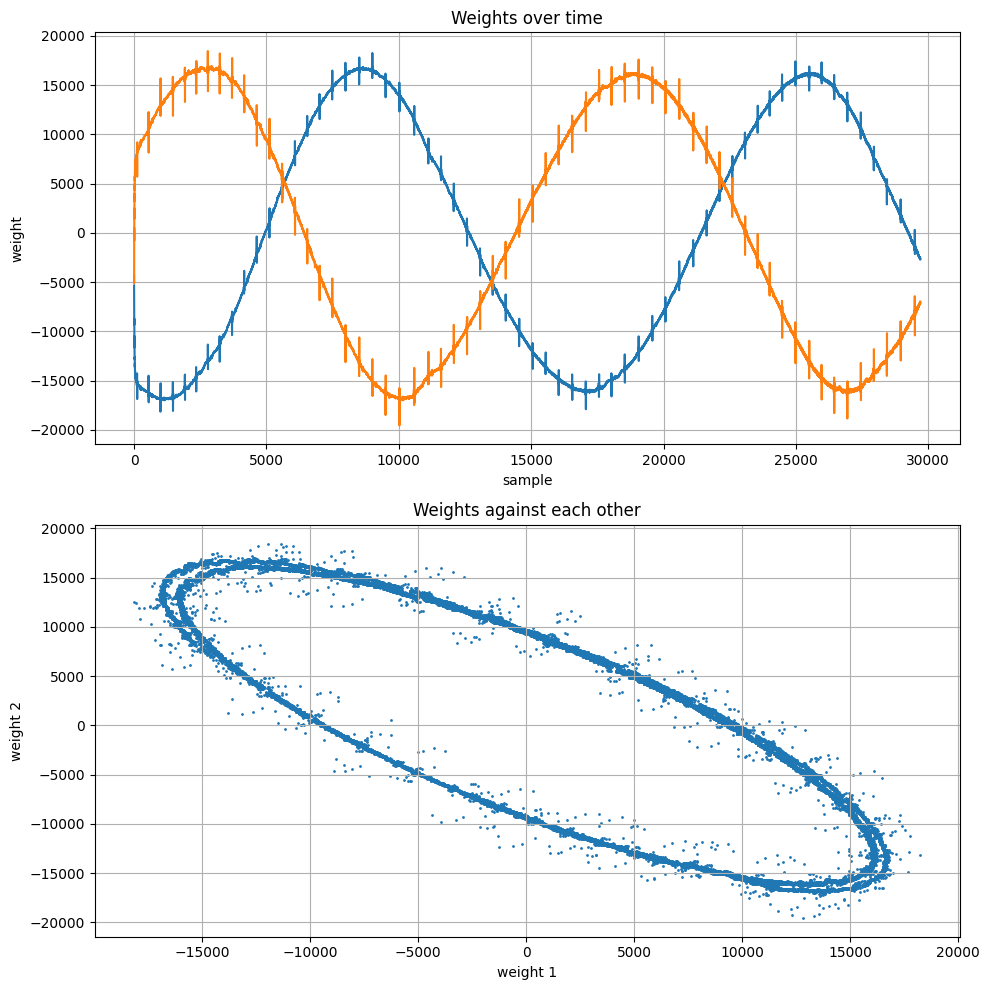

In [11]:
# plot weights over time and against each other
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(w)
ax[0].set_title('Weights over time')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('weight')
ax[0].grid()
viridis = plt.get_cmap('viridis')
ax[1].scatter(w[:, 0], w[:, 1], cmap=viridis,s=1)
ax[1].set_title('Weights against each other')
ax[1].set_xlabel('weight 1')
ax[1].set_ylabel('weight 2')
ax[1].grid()
plt.tight_layout()
plt.show()

## 6  Adjust your parameters μ and the number of filter coefficients and see how good results you can acheive. If possible, estimate the improvement in signal-to-noise ratio.

In [ ]:
# try with ntaps = 3
ntaps = 3

granularity = 0.05

# test {2,3,4} x {0.0, granularity, ..., upper_limit_for_learning_rate_with_lms} combinations
for taps in [2,3,4]:
    for mu in np.arange(0.0, upper_limit_for_learning_rate_with_lms, granularity): # [0.0, 0.05, ..., upper_limit_for_learning_rate_with_lms]
        lms_result: LmsResult = lms_filter(x, ecg, mu, taps)
        # y = lms_result.y
        err = lms_result.err
        mse = np.mean(err**2)
        if mse < 0.0001:
            print(f'Converged with {taps} taps and mu = {mu:.2f}')
            break